# 임포트

In [37]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
import csv

from Func import * # 별: all

고쳐야할 것
Feature 크기를 자꾸 바꿔서 모델들을 불러왔을 때, 예측을 입력해도 안댐
Gov


# 하이퍼 파라미터 정의

In [38]:
USE_CUDA= torch.cuda.is_available()
DEVICE= torch.device("cuda"if USE_CUDA else "cpu")
print("다음 기기로 학습합니다: ", DEVICE)

random.seed(42)
torch.manual_seed(42)
if DEVICE == 'cuda':
    torch.cuda.manual_seed_all(42)

BATCH_SIZE = 144
LR = 5e-4
LR_STEP = 3
LR_GAMMA = 0.9825
EPOCH = 100
TRAIN_RATIO = 0.6
VAL_RATIO = 0.8
criterion = nn.MSELoss().to(DEVICE)
scheduler = None

# True False
new_model_train = True
image_save = True

# MLP PINN OnlyPINN
base_model="MLP"
model_type = "PINN"

version = "ver6"
ep=f"EP{EPOCH}"
etc="_0710_rain_miss"
memo="rain이 오면 그 이후 10시간 데이터 삭제, 결측치 삭제"

model_name=f'{model_type}_{version}_{ep}{etc}'
save_model_path = f"../model/{model_name}.pt"
load_model_path = save_model_path
save_history_path = f"../history/{model_name[:model_name.find('_')]}_history{model_name[model_name.find('_'):]}.pt"
load_history_path=save_history_path

save_loss_path = f"../image/loss/{model_type}_loss_{version}_{ep}{etc}.png"
save_full_pred_path = f"../image/pred/{model_type}_fullpred_{version}_{ep}{etc}.png"
save_day_pred_path = f"../image/pred/{model_type}_0625pred_{version}_{ep}{etc}.png"

다음 기기로 학습합니다:  cpu


# 모델 정의

In [39]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        linear1= nn.Linear(10, 72)
        linear2= nn.Linear(72, 120)
        linear3= nn.Linear(120, 60)
        linear4= nn.Linear(60, 1)
        
        nn.init.xavier_uniform_(linear1.weight)
        nn.init.xavier_uniform_(linear2.weight)
        nn.init.xavier_uniform_(linear3.weight)
        nn.init.xavier_uniform_(linear4.weight)

        activ=nn.ELU()
        
        self.linear = nn.Sequential(linear1, activ,
                                    linear2, activ,
                                    linear3, activ,
                                    linear4
                                    )

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.linear(x)
        return x

# 데이터 준비

In [40]:
'''

# 사전 작업: 데이터에 NaN값을 빈칸으로 바꾸기(1022개)
path = '../../data/data_for_model_1.csv'
data = pd.read_csv(path)

# 데이터 중 NULL 값 있는지 확인
len(data)-data.count()

#무의미한 특성 2개 제거
data = data.drop(['Unnamed: 0'], axis = 1)
data = data.drop(['Unnamed: 15'], axis = 1)
time_data= pd.to_datetime(data['date'])
time_data= pd.DataFrame({'date': time_data})
time_data['year'] = time_data['date'].dt.year.astype('float64')
time_data['month'] = time_data['date'].dt.month.astype('float64')
time_data['day'] = time_data['date'].dt.day.astype('float64')
time_data['hour'] = time_data['date'].dt.hour.astype('float64')
time_data['minute'] = time_data['date'].dt.minute.astype('float64')
time_data = time_data.drop(['date'], axis = 1)

data = data.drop(['date'], axis = 1)
data = data[data['rail_direction']==0]
data = data.drop(['rail_direction'], axis = 1)

Rail = data.copy()
Rail.fillna({'wind_speed':Rail['wind_speed'].mean()}, inplace=True)

# 각 값의 크기가 달라서 MinMaxScaler
dmin=Rail.min()
dmax=Rail.max()
Rail_ready= (Rail-dmin)/(dmax-dmin)
Rail_ready=pd.concat([time_data[:len(Rail_ready)], Rail_ready], axis=1)
Past_Rail_Tem=Rail_ready[]
Rail_ready.info()

# 입력변수와 출력값 분리
X = Rail_ready.iloc[:, :-1]
Y = Rail_ready.iloc[:,-1]

# Dataframe으로 되어있는 값을 계산을 위해 array로 변경
X_np= X.values
Y_np= Y.values

X_t, Y_t= torch.tensor(X_np, dtype=torch.float32), torch.tensor(Y_np, dtype=torch.float32).view(-1,1)

X_train, X_val, X_test = X_t[:int(len(X_t)*TRAIN_RATIO)], X_t[int(len(X_t)*TRAIN_RATIO):int(len(X_t)*VAL_RATIO)] ,X_t[int(len(X_t)*VAL_RATIO):]
Y_train, Y_val, Y_test = Y_t[:int(len(Y_t)*TRAIN_RATIO)], Y_t[int(len(Y_t)*TRAIN_RATIO):int(len(Y_t)*VAL_RATIO)] ,Y_t[int(len(Y_t)*VAL_RATIO):]

X_0=X_train[0].numpy()
Y_0=Y_train[0].numpy()

train_set=TensorDataset(X_train[1:], Y_train[1:])
val_set=TensorDataset(X_val, Y_val)
test_set=TensorDataset(X_test, Y_test)

train_loader=DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=False)
val_loader=DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False) 
test_loader=DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

'''

"\n\n# 사전 작업: 데이터에 NaN값을 빈칸으로 바꾸기(1022개)\npath = '../../data/data_for_model_1.csv'\ndata = pd.read_csv(path)\n\n# 데이터 중 NULL 값 있는지 확인\nlen(data)-data.count()\n\n#무의미한 특성 2개 제거\ndata = data.drop(['Unnamed: 0'], axis = 1)\ndata = data.drop(['Unnamed: 15'], axis = 1)\ntime_data= pd.to_datetime(data['date'])\ntime_data= pd.DataFrame({'date': time_data})\ntime_data['year'] = time_data['date'].dt.year.astype('float64')\ntime_data['month'] = time_data['date'].dt.month.astype('float64')\ntime_data['day'] = time_data['date'].dt.day.astype('float64')\ntime_data['hour'] = time_data['date'].dt.hour.astype('float64')\ntime_data['minute'] = time_data['date'].dt.minute.astype('float64')\ntime_data = time_data.drop(['date'], axis = 1)\n\ndata = data.drop(['date'], axis = 1)\ndata = data[data['rail_direction']==0]\ndata = data.drop(['rail_direction'], axis = 1)\n\nRail = data.copy()\nRail.fillna({'wind_speed':Rail['wind_speed'].mean()}, inplace=True)\n\n# 각 값의 크기가 달라서 MinMaxScaler\ndmin=Rail.min()\ndma

In [41]:

# 사전 작업: 데이터에 NaN값을 빈칸으로 바꾸기(1022개)
path = '../../data/data_for_model_1.csv'
data = pd.read_csv(path)

# 데이터 중 NULL 값 있는지 확인
len(data)-data.count()

#무의미한 특성 제거
data = data.drop(['Unnamed: 0'], axis = 1)
data = data.drop(['Unnamed: 15'], axis = 1)
data = data.drop(['date'], axis = 1)
data = data[data['rail_direction']==0]
data = data.drop(['rail_direction'], axis = 1)

Rail = data.copy()
Rail = Rail.fillna(Rail['wind_speed'].mean(),inplace=False)
Rail = Rail.astype({'wind_speed':'float64'})

past_rail_tem=pd.DataFrame(Rail['rail_temp'][1:]).reset_index(drop=True)
Rail=Rail[:-1].reset_index(drop=True)
past_rail_tem=past_rail_tem[Rail['rail_temp']>36].reset_index(drop=True)
past_rail_tem.columns=['past_rail_tem']
Rail=Rail[Rail['rail_temp']>36].reset_index(drop=True)
Rail=pd.concat([Rail,past_rail_tem], axis=1)

data_real_scale=Rail

# 각 값의 크기가 달라서 MinMaxScaler
dmin=data_real_scale.min()
dmax=data_real_scale.max()
Rail_ready= (data_real_scale-dmin)/(dmax-dmin)
# Rail_ready= data_real_scale ## scaling 안하기
Rail_ready.info() 

# 입력변수와 출력값 분리
X = Rail_ready.iloc[:, :-2]
Y = Rail_ready.iloc[:,-2:]


# Dataframe으로 되어있는 값을 계산을 위해 array로 변경
X_np= X.values
Y_np= Y.values
Y_now=Y_np[:,0]
Y_past=Y_np[:,1]

X_t, Y_t= torch.tensor(X_np, dtype=torch.float32), torch.tensor(Y_np, dtype=torch.float32).view(-1,2)

X_train, X_val, X_test = X_t[:int(len(X_t)*TRAIN_RATIO)], X_t[int(len(X_t)*TRAIN_RATIO):int(len(X_t)*VAL_RATIO)] ,X_t[int(len(X_t)*VAL_RATIO):]
Y_train, Y_val, Y_test = Y_t[:int(len(Y_t)*TRAIN_RATIO)], Y_t[int(len(Y_t)*TRAIN_RATIO):int(len(Y_t)*VAL_RATIO)] ,Y_t[int(len(Y_t)*VAL_RATIO):]

train_set=TensorDataset(X_train, Y_train)
val_set=TensorDataset(X_val, Y_val)
test_set=TensorDataset(X_test, Y_test)

train_loader=DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=False)
val_loader=DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False) 
test_loader=DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5928 entries, 0 to 5927
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   air_temp        5928 non-null   float64
 1   TSI             5928 non-null   float64
 2   azimuth         5928 non-null   float64
 3   altitude        5928 non-null   float64
 4   solar_rad       5928 non-null   float64
 5   High_solar_rad  5928 non-null   float64
 6   casi            5928 non-null   float64
 7   humidity        5928 non-null   float64
 8   rain            5928 non-null   float64
 9   wind_speed      5928 non-null   float64
 10  wind_direction  5928 non-null   float64
 11  rail_temp       5928 non-null   float64
 12  past_rail_tem   5928 non-null   float64
dtypes: float64(13)
memory usage: 602.2 KB


In [42]:
# 사전 작업: 데이터에 NaN값을 빈칸으로 바꾸기(1022개)
path = '../../data/data_for_model_3.csv'
data = pd.read_csv(path)

# 데이터 중 NULL 값 있는지 확인
len(data)-data.count()

#무의미한 특성 제거
data = data.drop(['Unnamed: 0'], axis = 1).drop(['Unnamed: 15'], axis = 1)
# data = data[data['rail_direction']==0]; data = data.drop(['rail_direction'], axis = 1)

Rail = data.copy()
Rail = Rail.fillna(Rail['wind_speed'].mean(),inplace=False); Rail = Rail.astype({'wind_speed':'float64'})
time_data= pd.to_datetime(data['date'])
Rail['date']=time_data

# 10분 간격으로 시간 인덱스 생성
time_index = pd.date_range(start=Rail['date'][0], end=Rail['date'][Rail.index[-1]], freq='10min')

# DataFrame 생성
df = pd.DataFrame(index=time_index)

merged_df = pd.merge(df, Rail, left_index=True, right_on='date', how='left').sort_index()
shift_df = merged_df['rail_temp'].shift(periods=1).rename('past_rail_temp')
final_df=pd.concat([merged_df,shift_df],axis=1)
final_df=final_df.dropna()

condition = final_df['rain'] > 0
index_to_remove = final_df[condition].index
index_to_remove_extended = index_to_remove.union([idx + i for idx in index_to_remove for i in range(1, 60)])
data_real_scale = final_df.drop(index_to_remove_extended).drop(['rain'], axis = 1)
data_real_scale = data_real_scale.drop(['date'], axis = 1)
data_real_scale = data_real_scale[data_real_scale['rail_direction']==0]; data_real_scale = data_real_scale.drop(['rail_direction'], axis = 1)

# 각 값의 크기가 달라서 MinMaxScaler
dmin=data_real_scale.min()
dmax=data_real_scale.max()
Rail_ready= (data_real_scale-dmin)/(dmax-dmin)
# Rail_ready= data_real_scale ## scaling 안하기
Rail_ready.info() 

# 입력변수와 출력값 분리
X = Rail_ready.iloc[:, :-2]
Y = Rail_ready.iloc[:,-2:]


# Dataframe으로 되어있는 값을 계산을 위해 array로 변경
X_np= X.values
Y_np= Y.values
Y_now=Y_np[:,0]
Y_past=Y_np[:,1]

X_t, Y_t= torch.tensor(X_np, dtype=torch.float32), torch.tensor(Y_np, dtype=torch.float32).view(-1,2)

X_train, X_val, X_test = X_t[:int(len(X_t)*TRAIN_RATIO)], X_t[int(len(X_t)*TRAIN_RATIO):int(len(X_t)*VAL_RATIO)] ,X_t[int(len(X_t)*VAL_RATIO):]
Y_train, Y_val, Y_test = Y_t[:int(len(Y_t)*TRAIN_RATIO)], Y_t[int(len(Y_t)*TRAIN_RATIO):int(len(Y_t)*VAL_RATIO)] ,Y_t[int(len(Y_t)*VAL_RATIO):]

train_set=TensorDataset(X_train, Y_train)
val_set=TensorDataset(X_val, Y_val)
test_set=TensorDataset(X_test, Y_test)

train_loader=DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=False)
val_loader=DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False) 
test_loader=DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

<class 'pandas.core.frame.DataFrame'>
Index: 41366 entries, 1.0 to 48195.0
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   air_temp        41366 non-null  float64
 1   TSI             41366 non-null  float64
 2   azimuth         41366 non-null  float64
 3   altitude        41366 non-null  float64
 4   solar_rad       41366 non-null  float64
 5   High_solar_rad  41366 non-null  float64
 6   casi            41366 non-null  float64
 7   humidity        41366 non-null  float64
 8   wind_speed      41366 non-null  float64
 9   wind_direction  41366 non-null  float64
 10  rail_temp       41366 non-null  float64
 11  past_rail_temp  41366 non-null  float64
dtypes: float64(12)
memory usage: 4.1 MB


# 모델 훈련

In [43]:
random.seed(42)
torch.manual_seed(42)
if DEVICE == 'cuda':
    torch.cuda.manual_seed_all(42)

exec(f"model = {base_model}().to(DEVICE)") # exec: 문자열을 코드로 인식하게 함. 단, 실행전에는 코드로 인식해서 모델을 정의한 사실을 코드에서 몰라서 오류문구를 띄울 수 있음
model=model
print(model)

if new_model_train:
    optimizer = optim.Adam(model.parameters(), lr=LR)
    loss_history = Train(model,model_type, train_loader, val_loader, criterion, optimizer, 
          EPOCH, BATCH_SIZE, TRAIN_RATIO, memo,
          save_model_path, save_history_path, d_max=dmax, d_min=dmin, LR_STEP=LR_STEP, LR_GAMMA=LR_GAMMA)
    

MLP(
  (linear): Sequential(
    (0): Linear(in_features=10, out_features=72, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=72, out_features=120, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=120, out_features=60, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=60, out_features=1, bias=True)
  )
)
Epoch: 1, current_LR = 0.000500


  0%|          | 0/173 [00:00<?, ?it/s]c:\Users\AML_1\Desktop\coder\rail_project\rail_venv\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([144])) that is different to the input size (torch.Size([144, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 80%|████████  | 139/173 [00:00<00:00, 352.13it/s]c:\Users\AML_1\Desktop\coder\rail_project\rail_venv\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([51])) that is different to the input size (torch.Size([51, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/58 [00:00<?, ?it/s]            c:\Users\AML_1\Desktop\coder\rail_project\rail_venv\lib\site-packages\torch\nn\modules\loss.py:536: UserWarni

train loss: 0.00537749, val loss: 0.00102252, time: 1 s
--------------------
Epoch: 2, current_LR = 0.000500


train loss: 0.00076599, val loss: 0.00055152, time: 1 s
--------------------
Epoch: 3, current_LR = 0.000500


train loss: 0.00036660, val loss: 0.00091316, time: 1 s
--------------------
Epoch: 4, current_LR = 0.000491


train loss: 0.00023412, val loss: 0.00112964, time: 1 s
--------------------
Epoch: 5, current_LR = 0.000491


train loss: 0.00018682, val loss: 0.00159742, time: 1 s
--------------------
Epoch: 6, current_LR = 0.000491


train loss: 0.00021744, val loss: 0.00171682, time: 1 s
--------------------
Epoch: 7, current_LR = 0.000483


train loss: 0.00023896, val loss: 0.00152094, time: 1 s
--------------------
Epoch: 8, current_LR = 0.000483


train loss: 0.00023823, val loss: 0.00127692, time: 1 s
--------------------
Epoch: 9, current_LR = 0.000483


train loss: 0.00022846, val loss: 0.00103717, time: 1 s
--------------------
Epoch: 10, current_LR = 0.000474


train loss: 0.00021081, val loss: 0.00078409, time: 1 s
--------------------
Epoch: 11, current_LR = 0.000474


train loss: 0.00019086, val loss: 0.00060461, time: 1 s
--------------------
Epoch: 12, current_LR = 0.000474


train loss: 0.00017951, val loss: 0.00044615, time: 1 s
--------------------
Epoch: 13, current_LR = 0.000466


train loss: 0.00017143, val loss: 0.00033009, time: 1 s
--------------------
Epoch: 14, current_LR = 0.000466


train loss: 0.00017198, val loss: 0.00029940, time: 1 s
--------------------
Epoch: 15, current_LR = 0.000466


train loss: 0.00017997, val loss: 0.00031936, time: 1 s
--------------------
Epoch: 16, current_LR = 0.000458


train loss: 0.00019103, val loss: 0.00038894, time: 1 s
--------------------
Epoch: 17, current_LR = 0.000458


train loss: 0.00020716, val loss: 0.00044860, time: 1 s
--------------------
Epoch: 18, current_LR = 0.000458


train loss: 0.00021697, val loss: 0.00046390, time: 1 s
--------------------
Epoch: 19, current_LR = 0.000450


train loss: 0.00021577, val loss: 0.00042694, time: 1 s
--------------------
Epoch: 20, current_LR = 0.000450


train loss: 0.00020235, val loss: 0.00037402, time: 1 s
--------------------
Epoch: 21, current_LR = 0.000450


train loss: 0.00018472, val loss: 0.00035080, time: 1 s
--------------------
Epoch: 22, current_LR = 0.000442


train loss: 0.00017383, val loss: 0.00034156, time: 1 s
--------------------
Epoch: 23, current_LR = 0.000442


train loss: 0.00016900, val loss: 0.00033213, time: 1 s
--------------------
Epoch: 24, current_LR = 0.000442


train loss: 0.00016469, val loss: 0.00032772, time: 1 s
--------------------
Epoch: 25, current_LR = 0.000434


train loss: 0.00016098, val loss: 0.00032304, time: 1 s
--------------------
Epoch: 26, current_LR = 0.000434


train loss: 0.00015849, val loss: 0.00031543, time: 1 s
--------------------
Epoch: 27, current_LR = 0.000434


train loss: 0.00015481, val loss: 0.00031091, time: 1 s
--------------------
Epoch: 28, current_LR = 0.000427


train loss: 0.00015127, val loss: 0.00030588, time: 1 s
--------------------
Epoch: 29, current_LR = 0.000427


train loss: 0.00014873, val loss: 0.00030121, time: 1 s
--------------------
Epoch: 30, current_LR = 0.000427


train loss: 0.00014556, val loss: 0.00029854, time: 1 s
--------------------
Epoch: 31, current_LR = 0.000419


train loss: 0.00014242, val loss: 0.00029558, time: 1 s
--------------------
Epoch: 32, current_LR = 0.000419


train loss: 0.00014023, val loss: 0.00029528, time: 1 s
--------------------
Epoch: 33, current_LR = 0.000419


train loss: 0.00013785, val loss: 0.00029583, time: 1 s
--------------------
Epoch: 34, current_LR = 0.000412


train loss: 0.00013520, val loss: 0.00029629, time: 1 s
--------------------
Epoch: 35, current_LR = 0.000412


train loss: 0.00013360, val loss: 0.00030094, time: 1 s
--------------------
Epoch: 36, current_LR = 0.000412


train loss: 0.00013205, val loss: 0.00030513, time: 1 s
--------------------
Epoch: 37, current_LR = 0.000405


train loss: 0.00012980, val loss: 0.00030971, time: 1 s
--------------------
Epoch: 38, current_LR = 0.000405


train loss: 0.00012864, val loss: 0.00031957, time: 1 s
--------------------
Epoch: 39, current_LR = 0.000405


train loss: 0.00012767, val loss: 0.00032835, time: 1 s
--------------------
Epoch: 40, current_LR = 0.000397


train loss: 0.00012568, val loss: 0.00033944, time: 1 s
--------------------
Epoch: 41, current_LR = 0.000397


train loss: 0.00012474, val loss: 0.00035590, time: 1 s
--------------------
Epoch: 42, current_LR = 0.000397


train loss: 0.00012404, val loss: 0.00037139, time: 1 s
--------------------
Epoch: 43, current_LR = 0.000391


train loss: 0.00012236, val loss: 0.00039087, time: 1 s
--------------------
Epoch: 44, current_LR = 0.000391


train loss: 0.00012157, val loss: 0.00041371, time: 1 s
--------------------
Epoch: 45, current_LR = 0.000391


train loss: 0.00012105, val loss: 0.00043501, time: 1 s
--------------------
Epoch: 46, current_LR = 0.000384


train loss: 0.00011990, val loss: 0.00046041, time: 1 s
--------------------
Epoch: 47, current_LR = 0.000384


train loss: 0.00011949, val loss: 0.00048583, time: 1 s
--------------------
Epoch: 48, current_LR = 0.000384


train loss: 0.00011939, val loss: 0.00050880, time: 1 s
--------------------
Epoch: 49, current_LR = 0.000377


train loss: 0.00011911, val loss: 0.00053615, time: 1 s
--------------------
Epoch: 50, current_LR = 0.000377


train loss: 0.00011945, val loss: 0.00056067, time: 1 s
--------------------
Epoch: 51, current_LR = 0.000377


train loss: 0.00012018, val loss: 0.00058230, time: 1 s
--------------------
Epoch: 52, current_LR = 0.000370


train loss: 0.00012135, val loss: 0.00060883, time: 1 s
--------------------
Epoch: 53, current_LR = 0.000370


train loss: 0.00012276, val loss: 0.00062761, time: 1 s
--------------------
Epoch: 54, current_LR = 0.000370


train loss: 0.00012372, val loss: 0.00064318, time: 1 s
--------------------
Epoch: 55, current_LR = 0.000364


train loss: 0.00012381, val loss: 0.00065969, time: 1 s
--------------------
Epoch: 56, current_LR = 0.000364


train loss: 0.00012313, val loss: 0.00066229, time: 1 s
--------------------
Epoch: 57, current_LR = 0.000364


train loss: 0.00012145, val loss: 0.00066337, time: 1 s
--------------------
Epoch: 58, current_LR = 0.000358


train loss: 0.00011960, val loss: 0.00066792, time: 1 s
--------------------
Epoch: 59, current_LR = 0.000358


train loss: 0.00011820, val loss: 0.00066878, time: 1 s
--------------------
Epoch: 60, current_LR = 0.000358


train loss: 0.00011662, val loss: 0.00067153, time: 1 s
--------------------
Epoch: 61, current_LR = 0.000351


train loss: 0.00011502, val loss: 0.00067809, time: 1 s
--------------------
Epoch: 62, current_LR = 0.000351


train loss: 0.00011397, val loss: 0.00068092, time: 1 s
--------------------
Epoch: 63, current_LR = 0.000351


train loss: 0.00011281, val loss: 0.00068444, time: 1 s
--------------------
Epoch: 64, current_LR = 0.000345


train loss: 0.00011138, val loss: 0.00069072, time: 1 s
--------------------
Epoch: 65, current_LR = 0.000345


train loss: 0.00011066, val loss: 0.00069273, time: 1 s
--------------------
Epoch: 66, current_LR = 0.000345


train loss: 0.00010987, val loss: 0.00069482, time: 1 s
--------------------
Epoch: 67, current_LR = 0.000339


train loss: 0.00010859, val loss: 0.00069801, time: 1 s
--------------------
Epoch: 68, current_LR = 0.000339


train loss: 0.00010814, val loss: 0.00069671, time: 1 s
--------------------
Epoch: 69, current_LR = 0.000339


train loss: 0.00010754, val loss: 0.00069541, time: 1 s
--------------------
Epoch: 70, current_LR = 0.000333


train loss: 0.00010637, val loss: 0.00069503, time: 1 s
--------------------
Epoch: 71, current_LR = 0.000333


train loss: 0.00010610, val loss: 0.00069242, time: 1 s
--------------------
Epoch: 72, current_LR = 0.000333


train loss: 0.00010571, val loss: 0.00069005, time: 1 s
--------------------
Epoch: 73, current_LR = 0.000327


train loss: 0.00010471, val loss: 0.00068868, time: 1 s
--------------------
Epoch: 74, current_LR = 0.000327


train loss: 0.00010459, val loss: 0.00068703, time: 1 s
--------------------
Epoch: 75, current_LR = 0.000327


train loss: 0.00010435, val loss: 0.00068512, time: 1 s
--------------------
Epoch: 76, current_LR = 0.000322


train loss: 0.00010345, val loss: 0.00068435, time: 1 s
--------------------
Epoch: 77, current_LR = 0.000322


train loss: 0.00010337, val loss: 0.00068436, time: 1 s
--------------------
Epoch: 78, current_LR = 0.000322


train loss: 0.00010318, val loss: 0.00068341, time: 1 s
--------------------
Epoch: 79, current_LR = 0.000316


train loss: 0.00010227, val loss: 0.00068357, time: 1 s
--------------------
Epoch: 80, current_LR = 0.000316


train loss: 0.00010215, val loss: 0.00068461, time: 1 s
--------------------
Epoch: 81, current_LR = 0.000316


train loss: 0.00010194, val loss: 0.00068452, time: 1 s
--------------------
Epoch: 82, current_LR = 0.000310


train loss: 0.00010101, val loss: 0.00068547, time: 1 s
--------------------
Epoch: 83, current_LR = 0.000310


train loss: 0.00010085, val loss: 0.00068633, time: 1 s
--------------------
Epoch: 84, current_LR = 0.000310


train loss: 0.00010060, val loss: 0.00068564, time: 1 s
--------------------
Epoch: 85, current_LR = 0.000305


train loss: 0.00009964, val loss: 0.00068540, time: 1 s
--------------------
Epoch: 86, current_LR = 0.000305


train loss: 0.00009937, val loss: 0.00068431, time: 1 s
--------------------
Epoch: 87, current_LR = 0.000305


train loss: 0.00009901, val loss: 0.00068232, time: 1 s
--------------------
Epoch: 88, current_LR = 0.000300


train loss: 0.00009801, val loss: 0.00068115, time: 1 s
--------------------
Epoch: 89, current_LR = 0.000300


train loss: 0.00009767, val loss: 0.00067883, time: 1 s
--------------------
Epoch: 90, current_LR = 0.000300


train loss: 0.00009727, val loss: 0.00067612, time: 1 s
--------------------
Epoch: 91, current_LR = 0.000294


train loss: 0.00009635, val loss: 0.00067363, time: 1 s
--------------------
Epoch: 92, current_LR = 0.000294


train loss: 0.00009599, val loss: 0.00066917, time: 1 s
--------------------
Epoch: 93, current_LR = 0.000294


train loss: 0.00009555, val loss: 0.00066446, time: 1 s
--------------------
Epoch: 94, current_LR = 0.000289


train loss: 0.00009468, val loss: 0.00065931, time: 1 s
--------------------
Epoch: 95, current_LR = 0.000289


train loss: 0.00009426, val loss: 0.00065251, time: 1 s
--------------------
Epoch: 96, current_LR = 0.000289


train loss: 0.00009379, val loss: 0.00064594, time: 1 s
--------------------
Epoch: 97, current_LR = 0.000284


train loss: 0.00009299, val loss: 0.00063846, time: 1 s
--------------------
Epoch: 98, current_LR = 0.000284


train loss: 0.00009257, val loss: 0.00063063, time: 1 s
--------------------
Epoch: 99, current_LR = 0.000284


train loss: 0.00009216, val loss: 0.00062336, time: 1 s
--------------------
Epoch: 100, current_LR = 0.000279


train loss: 0.00009151, val loss: 0.00061462, time: 1 s
--------------------


# 모델 Load하기

In [44]:
model_load = torch.load(load_model_path, map_location=DEVICE)
load_history = torch.load(load_history_path, map_location=DEVICE)
print(model_load['memo'])
print(model_load['model'])

rain이 오면 그 이후 10시간 데이터 삭제, 결측치 삭제
MLP(
  (linear): Sequential(
    (0): Linear(in_features=10, out_features=72, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=72, out_features=120, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=120, out_features=60, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=60, out_features=1, bias=True)
  )
)


# 모델 평가하기

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 [Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0, '1.0')])

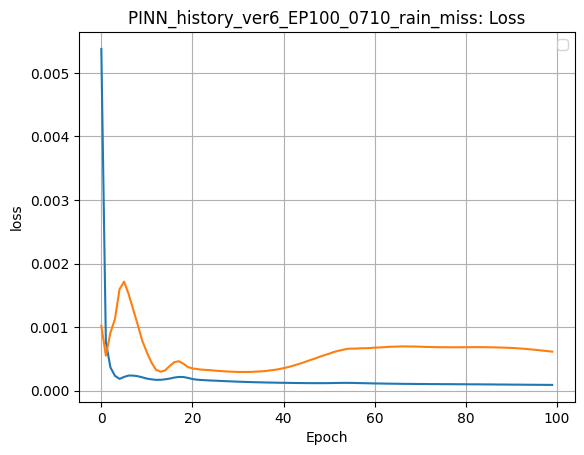

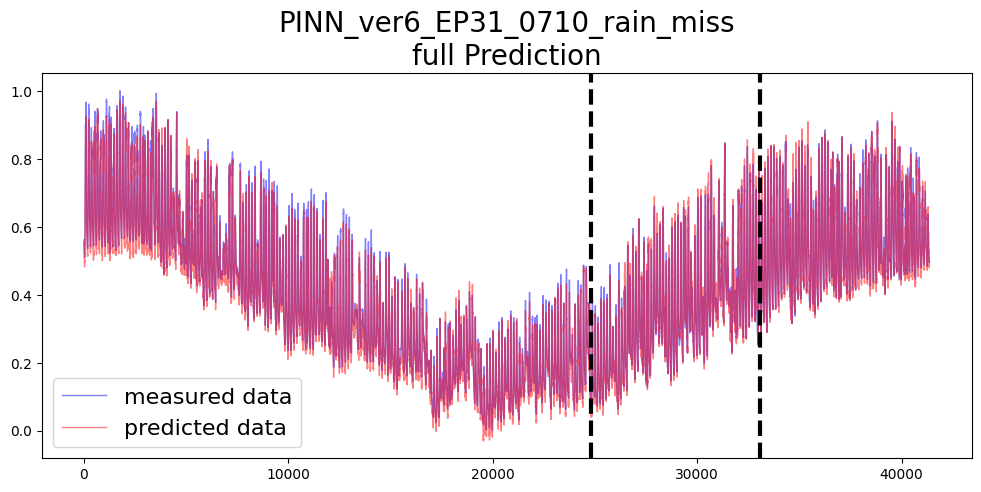

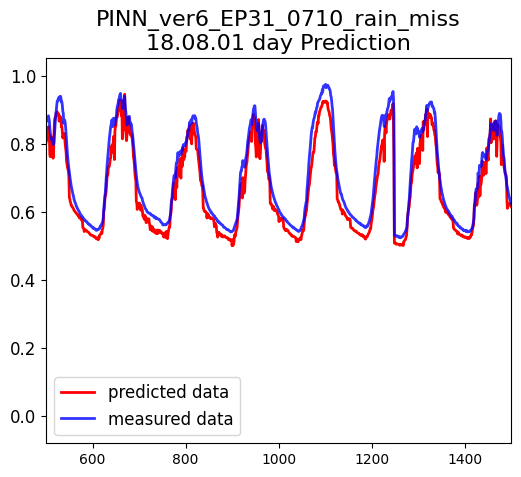

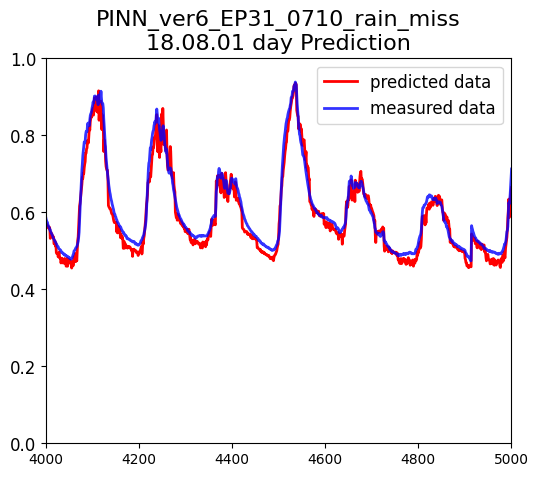

In [45]:
list_train=[]; list_val=[]
for _ in load_history['loss_history']['train']:
    list_train.append(_.item())
for _ in load_history['loss_history']['val']:
    list_val.append(_.item()) 

plt.plot(list_train)
plt.plot(list_val)
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.title(f"{model_type}_history_{version}_{ep}{etc}: Loss")
plt.legend()
plt.grid()
if image_save:
    plt.savefig(save_loss_path)

with torch.no_grad():
    model_load['model'].eval()
    pred=model_load['model'](X_t.to(DEVICE))
    pred=pred.cpu().detach().numpy()
    
plt.figure(figsize=(12,5))
plt.plot(Y_now, color='blue', alpha=0.5, linewidth=1, label='measured data')
plt.plot(pred, color='red', alpha=0.5,linewidth=1,  label='predicted data')
plt.legend(loc='lower left',fontsize=16)
plt.axvline(x=len(pred)*TRAIN_RATIO, color='black', linestyle='--', linewidth=3)
plt.axvline(x=len(pred)*VAL_RATIO, color='black', linestyle='--', linewidth=3)
plt.title(f"{model_type}_{version}_{ep[:2]}{model_load['ep']}{etc}\nfull Prediction",fontsize=20) 
if image_save:
    plt.savefig(save_full_pred_path)
    
plt.figure(figsize=(6,5))
plt.plot(pred,'r',linewidth=2, label='predicted data')
plt.plot(Y_now, 'b',linewidth=2, alpha=0.8, label='measured data')
plt.legend(fontsize=12)
plt.xlim(500,1500)
#plt.ylim(0.4, 1)
plt.title(f"{model_type}_{version}_{ep[:2]}{model_load['ep']}{etc}\n18.08.01 day Prediction",fontsize=16) 
#plt.xticks([2880,2898,2916,2934,2952,2970,2988,3004,3023],labels=['00:00','03:00','06:00' ,'09:00','12:00','15:00','18:00','21:00', '00:00'],fontsize=12, rotation=45)
plt.yticks(fontsize=12)
if image_save:
    plt.savefig(save_day_pred_path)
    

plt.figure(figsize=(6,5))
plt.plot(pred,'r',linewidth=2, label='predicted data')
plt.plot(Y_now, 'b',linewidth=2, alpha=0.8, label='measured data')
plt.legend(fontsize=12)
plt.xlim(4000,5000)
plt.ylim(0, 1)
plt.title(f"{model_type}_{version}_{ep[:2]}{model_load['ep']}{etc}\n18.08.01 day Prediction",fontsize=16) 
#plt.xticks([2880,2898,2916,2934,2952,2970,2988,3004,3023],labels=['00:00','03:00','06:00' ,'09:00','12:00','15:00','18:00','21:00', '00:00'],fontsize=12, rotation=45)
plt.yticks(fontsize=12)

In [46]:
with torch.no_grad():
    model_load['model'].eval()
    pred_train=model_load['model'](X_train.to(DEVICE)).cpu()
    pred_val=model_load['model'](X_val.to(DEVICE)).cpu()
    pred_test=model_load['model'](X_test.to(DEVICE)).cpu()

#pred={"train":["r2":[],"mae":[],"mse":[]], "val":["r2":[],"mae":[],"mse":[]]}

train_pred = {"r2":[],"mae":[],"mse":[]}
val_pred = {"r2":[],"mae":[],"mse":[]}
test_pred = {"r2":[],"mae":[],"mse":[]}

print("train")
print("R2 =",r2_score(Y_train[:,0], pred_train.detach().numpy()))
print("mae =",torch.from_numpy(np.array(mean_absolute_error(Y_train[:,0], pred_train.detach().numpy()))).item())
print("mse =",torch.from_numpy(np.array(mean_squared_error(Y_train[:,0], pred_train.detach().numpy()))).item())
print("mape", torch.from_numpy(np.array(mean_absolute_percentage_error(Y_train[:,0], pred_train.detach().numpy()))).item())

print("val")
print("R2 =",r2_score(Y_val[:,0], pred_val.detach().numpy()))
print("mae =",torch.from_numpy(np.array(mean_absolute_error(Y_val[:,0], pred_val.detach().numpy()))).item())
print("mse =",torch.from_numpy(np.array(mean_squared_error(Y_val[:,0], pred_val.detach().numpy()))).item())
print("mape", torch.from_numpy(np.array(mean_absolute_percentage_error(Y_val[:,0], pred_val.detach().numpy()))).item())

print("test")
print("R2 =",r2_score(Y_test[:,0], pred_test.detach().numpy()))
print("mae =",torch.from_numpy(np.array(mean_absolute_error(Y_test[:,0], pred_test.detach().numpy()))).item())
print("mse =",torch.from_numpy(np.array(mean_squared_error(Y_test[:,0], pred_test.detach().numpy()))).item())
print("mape", torch.from_numpy(np.array(mean_absolute_percentage_error(Y_test[:,0], pred_test.detach().numpy()))).item())



# 추가해야할 것: 각 퍼포먼스를 판다스를 이용하고 csv파일로 저장하기

train
R2 = 0.9865265708992692
mae = 0.01989910379052162
mse = 0.0006788739119656384
mape 3513426432.0
val
R2 = 0.9411005597208272
mae = 0.027843372896313667
mse = 0.0015905728796496987
mape 0.07999342679977417
test
R2 = 0.9496968737132538
mae = 0.02258661761879921
mse = 0.0010085050016641617
mape 0.03899906948208809


# 원하는 모델 불러와서 확인하기

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MLP(
  (linear): Sequential(
    (0): Linear(in_features=10, out_features=72, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=72, out_features=120, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=120, out_features=60, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=60, out_features=1, bias=True)
  )
)
train
R2 = 0.9810524273647101
mae = 0.02083721198141575
mse = 0.0009546949877403677
mape 1799543168.0
val
R2 = 0.8684187613114115
mae = 0.042022690176963806
mse = 0.0035533367190510035
mape 0.1152915433049202
test
R2 = 0.7384518226422252
mae = 0.057163503021001816
mse = 0.005243663210421801
mape 0.098636694252491


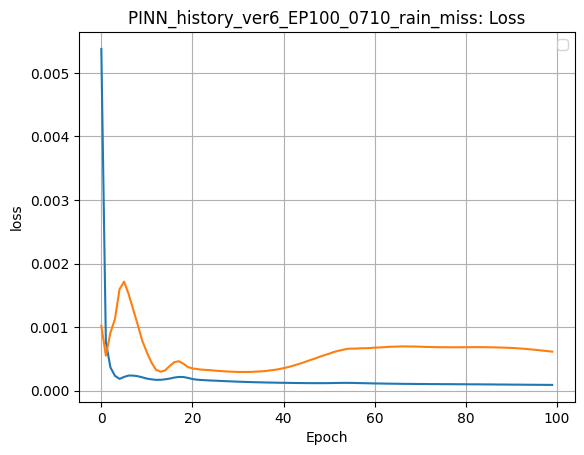

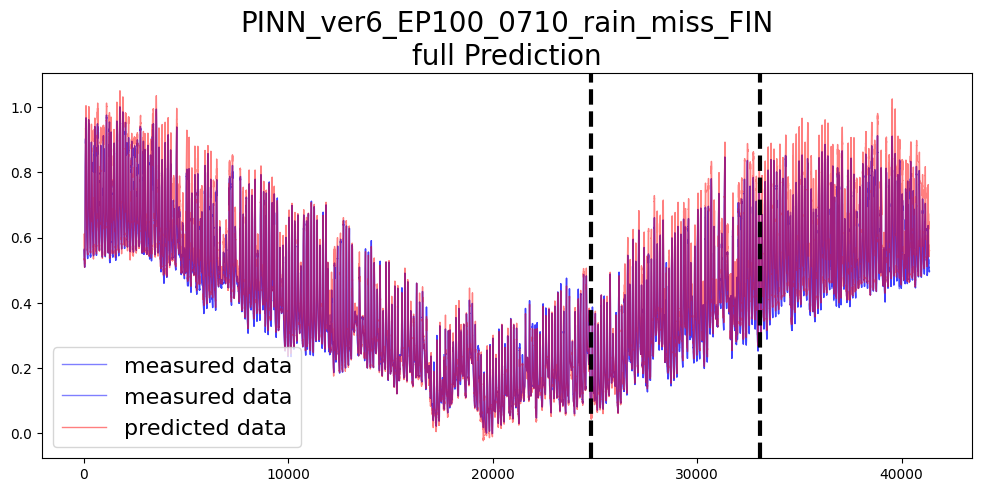

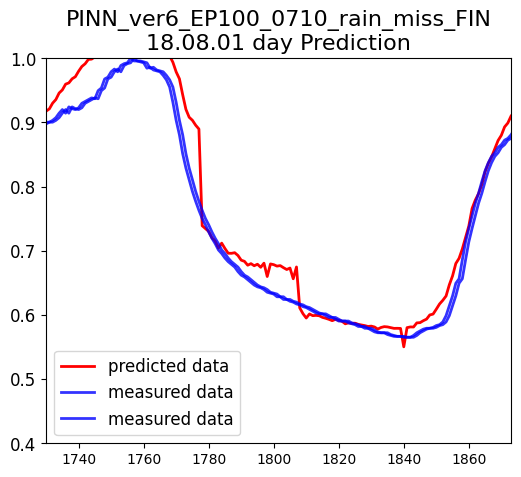

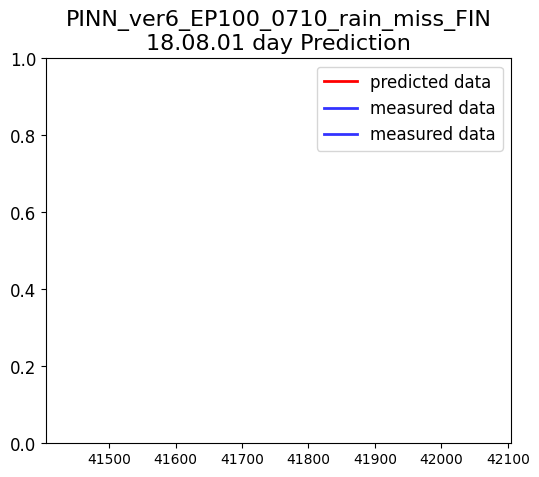

In [51]:

# True False
select_image_save=False

# select model
select_model_name="PINN_ver6_EP100_0710_rain_miss_FIN"
history_name=select_model_name[:select_model_name.find('_')]+"_history"+select_model_name[select_model_name.find('_'):-4]
select_load_model_path = f"../model/{select_model_name}.pt"
select_load_hitsory_path= f"../history/{history_name}.pt"

# save path
select_save_full_pred_path = f"../image/pred/{select_model_name}.png"
select_save_day_pred_path = f"../image/pred/{select_model_name}.png"

# select model load
model_load = torch.load(select_load_model_path, map_location=DEVICE)
load_history = torch.load(select_load_hitsory_path, map_location=DEVICE)
#print(model_load['memo'])
print(model_load['model'])

list_train=[]; list_val=[]
for _ in load_history['loss_history']['train']:
    list_train.append(_.item())
for _ in load_history['loss_history']['val']:
    list_val.append(_.item()) 

plt.plot(list_train)
plt.plot(list_val)
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.title(f"{model_type}_history_{version}_{ep}{etc}: Loss")
plt.legend()
plt.grid()

with torch.no_grad():
    model_load['model'].eval()
    pred=model_load['model'](X_t.to(DEVICE))
    pred=pred.cpu().detach().numpy()
    
plt.figure(figsize=(12,5))
plt.plot(Y_np, color='blue', alpha=0.5, linewidth=1, label='measured data')
plt.plot(pred, color='red', alpha=0.5,linewidth=1,  label='predicted data')
plt.legend(loc='lower left',fontsize=16)
plt.axvline(x=len(pred)*TRAIN_RATIO, color='black', linestyle='--', linewidth=3)
plt.axvline(x=len(pred)*VAL_RATIO, color='black', linestyle='--', linewidth=3)
plt.title(f"{select_model_name}\nfull Prediction",fontsize=20) 
if select_image_save:
    plt.savefig(select_save_full_pred_path)

    
plt.figure(figsize=(6,5))
plt.plot(pred,'r',linewidth=2, label='predicted data')
plt.plot(Y_np, 'b',linewidth=2, alpha=0.8, label='measured data')
plt.legend(fontsize=12)
plt.xlim(1730,1873)
plt.ylim(0.4, 1)
plt.title(f"{select_model_name}\n18.08.01 day Prediction",fontsize=16) 
#plt.xticks([2880,2898,2916,2934,2952,2970,2988,3004,3023],labels=['00:00','03:00','06:00' ,'09:00','12:00','15:00','18:00','21:00', '00:00'],fontsize=12, rotation=45)
plt.yticks(fontsize=12)
if select_image_save:
    plt.savefig(select_save_day_pred_path)

    
    
with torch.no_grad():
    model_load['model'].eval()
    pred_train=model_load['model'](X_train.to(DEVICE)).cpu()
    pred_val=model_load['model'](X_val.to(DEVICE)).cpu()
    pred_test=model_load['model'](X_test.to(DEVICE)).cpu()

#pred={"train":["r2":[],"mae":[],"mse":[]], "val":["r2":[],"mae":[],"mse":[]]}

train_pred = {"r2":[],"mae":[],"mse":[]}
val_pred = {"r2":[],"mae":[],"mse":[]}
test_pred = {"r2":[],"mae":[],"mse":[]}

print("train")
print("R2 =",r2_score(Y_train[:,0], pred_train.detach().numpy()))
print("mae =",torch.from_numpy(np.array(mean_absolute_error(Y_train[:,0], pred_train.detach().numpy()))).item())
print("mse =",torch.from_numpy(np.array(mean_squared_error(Y_train[:,0], pred_train.detach().numpy()))).item())
print("mape", torch.from_numpy(np.array(mean_absolute_percentage_error(Y_train[:,0], pred_train.detach().numpy()))).item())

print("val")
print("R2 =",r2_score(Y_val[:,0], pred_val.detach().numpy()))
print("mae =",torch.from_numpy(np.array(mean_absolute_error(Y_val[:,0], pred_val.detach().numpy()))).item())
print("mse =",torch.from_numpy(np.array(mean_squared_error(Y_val[:,0], pred_val.detach().numpy()))).item())
print("mape", torch.from_numpy(np.array(mean_absolute_percentage_error(Y_val[:,0], pred_val.detach().numpy()))).item())

print("test")
print("R2 =",r2_score(Y_test[:,0], pred_test.detach().numpy()))
print("mae =",torch.from_numpy(np.array(mean_absolute_error(Y_test[:,0], pred_test.detach().numpy()))).item())
print("mse =",torch.from_numpy(np.array(mean_squared_error(Y_test[:,0], pred_test.detach().numpy()))).item())
print("mape", torch.from_numpy(np.array(mean_absolute_percentage_error(Y_test[:,0], pred_test.detach().numpy()))).item())

# 추가해야할 것: 각 퍼포먼스를 판다스를 이용하고 csv파일로 저장하기

plt.figure(figsize=(6,5))
plt.plot(pred,'r',linewidth=2, label='predicted data')
plt.plot(Y_np, 'b',linewidth=2, alpha=0.8, label='measured data')
plt.legend(fontsize=12)
plt.xlim(41615-210,41755+350)
plt.ylim(0, 1)
plt.title(f"{select_model_name}\n18.08.01 day Prediction",fontsize=16) 
#plt.xticks([2880,2898,2916,2934,2952,2970,2988,3004,3023],labels=['00:00','03:00','06:00' ,'09:00','12:00','15:00','18:00','21:00', '00:00'],fontsize=12, rotation=45)
plt.yticks(fontsize=12)
if select_image_save:
    plt.savefig(select_save_day_pred_path)


In [50]:
'''# True False
select_image_save=False

# select model
select_model_name="PINN_ver5_EP100_0705_dir0_const_FIN"
history_name=select_model_name[:4]+"_history"+select_model_name[4:-4]
select_load_model_path = f"../model/{select_model_name}.pt"
select_load_hitsory_path= f"../history/{history_name}.pt"

# save path
select_save_full_pred_path = f"../image/pred/{select_model_name}.png"
select_save_day_pred_path = f"../image/pred/{select_model_name}.png"

# select model load
model_load = torch.load(select_load_model_path, map_location=DEVICE)
load_history = torch.load(select_load_hitsory_path, map_location=DEVICE)

list_train=[]; list_val=[]
for _ in load_history['loss_history']['train']:
    list_train.append(_.item())
for _ in load_history['loss_history']['val']:
    list_val.append(_.item()) 

plt.plot(list_train)
plt.plot(list_val)
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.title(f"{model_type}_history_{version}_{ep}{etc}: Loss")
plt.legend()
plt.grid()

with torch.no_grad():
    model_load['model'].eval()
    pred=model_load['model'](X_t.to(DEVICE))
    pred=pred.cpu().detach().numpy()
    
plt.figure(figsize=(12,5))
plt.plot(Y_np, color='blue', alpha=0.5, linewidth=1, label='measured data')
plt.plot(pred, color='red', alpha=0.5,linewidth=1,  label='predicted data')
plt.legend(loc='lower left',fontsize=16)
plt.axvline(x=len(pred)*TRAIN_RATIO, color='black', linestyle='--', linewidth=3)
plt.axvline(x=len(pred)*VAL_RATIO, color='black', linestyle='--', linewidth=3)
plt.title(f"{select_model_name}\nfull Prediction",fontsize=20) 
if select_image_save:
    plt.savefig(select_save_full_pred_path)

    
plt.figure(figsize=(6,5))
plt.plot(pred,'r',linewidth=2, label='predicted data')
plt.plot(Y_np, 'b',linewidth=2, alpha=0.8, label='measured data')
plt.legend(fontsize=12)
plt.xlim(1730,1873)
plt.ylim(0.4, 1)
plt.title(f"{select_model_name}\n18.08.01 day Prediction",fontsize=16) 
#plt.xticks([2880,2898,2916,2934,2952,2970,2988,3004,3023],labels=['00:00','03:00','06:00' ,'09:00','12:00','15:00','18:00','21:00', '00:00'],fontsize=12, rotation=45)
plt.yticks(fontsize=12)
if select_image_save:
    plt.savefig(select_save_day_pred_path)

    
    
with torch.no_grad():
    model_load['model'].eval()
    pred_train=model_load['model'](X_train.to(DEVICE)).cpu()
    pred_val=model_load['model'](X_val.to(DEVICE)).cpu()
    pred_test=model_load['model'](X_test.to(DEVICE)).cpu()

#pred={"train":["r2":[],"mae":[],"mse":[]], "val":["r2":[],"mae":[],"mse":[]]}

train_pred = {"r2":[],"mae":[],"mse":[]}
val_pred = {"r2":[],"mae":[],"mse":[]}
test_pred = {"r2":[],"mae":[],"mse":[]}

print("train")
print("R2 =",r2_score(Y_train, pred_train.detach().numpy()))
print("mae =",torch.from_numpy(np.array(mean_absolute_error(Y_train, pred_train.detach().numpy()))).item())
print("mse =",torch.from_numpy(np.array(mean_squared_error(Y_train, pred_train.detach().numpy()))).item())
print("mape", torch.from_numpy(np.array(mean_absolute_percentage_error(Y_train, pred_train.detach().numpy()))).item())

print("val")
print("R2 =",r2_score(Y_val, pred_val.detach().numpy()))
print("mae =",torch.from_numpy(np.array(mean_absolute_error(Y_val, pred_val.detach().numpy()))).item())
print("mse =",torch.from_numpy(np.array(mean_squared_error(Y_val, pred_val.detach().numpy()))).item())
print("mape", torch.from_numpy(np.array(mean_absolute_percentage_error(Y_val, pred_val.detach().numpy()))).item())

print("test")
print("R2 =",r2_score(Y_test, pred_test.detach().numpy()))
print("mae =",torch.from_numpy(np.array(mean_absolute_error(Y_test, pred_test.detach().numpy()))).item())
print("mse =",torch.from_numpy(np.array(mean_squared_error(Y_test, pred_test.detach().numpy()))).item())
print("mape", torch.from_numpy(np.array(mean_absolute_percentage_error(Y_test, pred_test.detach().numpy()))).item())

# 추가해야할 것: 각 퍼포먼스를 판다스를 이용하고 csv파일로 저장하기
'''

'# True False\nselect_image_save=False\n\n# select model\nselect_model_name="PINN_ver5_EP100_0705_dir0_const_FIN"\nhistory_name=select_model_name[:4]+"_history"+select_model_name[4:-4]\nselect_load_model_path = f"../model/{select_model_name}.pt"\nselect_load_hitsory_path= f"../history/{history_name}.pt"\n\n# save path\nselect_save_full_pred_path = f"../image/pred/{select_model_name}.png"\nselect_save_day_pred_path = f"../image/pred/{select_model_name}.png"\n\n# select model load\nmodel_load = torch.load(select_load_model_path, map_location=DEVICE)\nload_history = torch.load(select_load_hitsory_path, map_location=DEVICE)\n\nlist_train=[]; list_val=[]\nfor _ in load_history[\'loss_history\'][\'train\']:\n    list_train.append(_.item())\nfor _ in load_history[\'loss_history\'][\'val\']:\n    list_val.append(_.item()) \n\nplt.plot(list_train)\nplt.plot(list_val)\nplt.xlabel(\'Epoch\')\nplt.ylabel(\'loss\')\nplt.title(f"{model_type}_history_{version}_{ep}{etc}: Loss")\nplt.legend()\nplt.gri

# END